(288, 2)
Largest TS: 2.949003333788665
2.95 & 75.00 & -75.00 \\ \hline
2.72 & 240.00 & 15.00 \\ \hline
2.35 & 255.00 & 0.00 \\ \hline
2.32 & 345.00 & -75.00 \\ \hline
2.28 & 120.00 & 30.00 \\ \hline
2.19 & 120.00 & 45.00 \\ \hline
2.17 & 105.00 & -75.00 \\ \hline
2.15 & 345.00 & 15.00 \\ \hline
2.12 & 180.00 & -15.00 \\ \hline
2.07 & 120.00 & 0.00 \\ \hline
2.05 & 45.00 & 0.00 \\ \hline
2.02 & 15.00 & -45.00 \\ \hline
2.00 & 255.00 & -30.00 \\ \hline
1.87 & 345.00 & -60.00 \\ \hline
1.84 & 210.00 & -60.00 \\ \hline
1.82 & 150.00 & -15.00 \\ \hline
1.78 & 345.00 & 75.00 \\ \hline
1.73 & 75.00 & 0.00 \\ \hline
1.67 & 225.00 & -15.00 \\ \hline
1.64 & 45.00 & 45.00 \\ \hline


<ipython-input-4-13ec525759d1>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcolormesh = ax.pcolormesh(np.deg2rad(every_pt[:, :, 0])-np.pi,


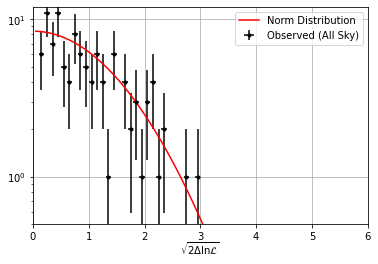

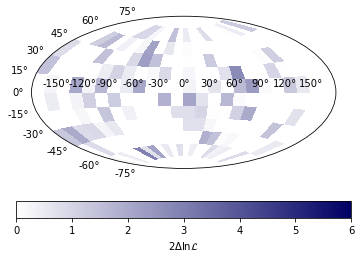

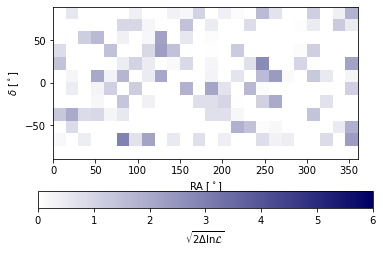

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
import IceCubeAnalysis


def main(fit_file_name, step_size=0.5):
    """
    Plots the results from the all-sky
    best-fit source search.
    Also prints out the most likely points on the sky.
    Parameters
    ----------
    fit_file_name : str
        Pickle file of the best-fit likelihood map.
    step_size : float
        The degrees step size to perform the all-sky search.
    """

    likelihood_map = np.load(fit_file_name,
                             allow_pickle=True)
    likelihood_map[likelihood_map <= 0.0] = 0.0

    cord_s, ra_len, dec_len = IceCubeAnalysis.prepare_skymap_coordinates(step_size)
    print(cord_s.shape)
    every_pt = np.reshape(cord_s, (ra_len, dec_len, cord_s.shape[-1]))

    sqrt_ts = np.sqrt(2.0 * likelihood_map)
    sqrt_ts[np.abs(every_pt[:, :, 1]) > 87.0] = 0.0

    print("Largest TS:", np.max(sqrt_ts))

    # Printout used to import table into Latex
    index_of_best = np.argsort(-1 * sqrt_ts.flatten())
    for i in index_of_best[:20]:
        print("%.2f & %.2f & %.2f \\\\ \hline" % (sqrt_ts.flatten()[i],
                                                  every_pt[:, :, 0].flatten()[i],
                                                  every_pt[:, :, 1].flatten()[i]))

    counts, bin_edges = np.histogram(sqrt_ts.flatten(),
                                     range=(0, 6),
                                     bins=60)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    # Fit the histogram with a gaussian.
    def log_gaus(x, a, b):
        return a + b * x * x

    bins_to_fit = counts != 0
    popt, pcov = curve_fit(log_gaus,
                           bin_centers[bins_to_fit],
                           np.log(counts[bins_to_fit]))

    fig, ax = plt.subplots()
    ax.set_yscale('log')
    ax.errorbar(bin_centers, counts, xerr=3/len(counts), yerr=np.sqrt(counts),
                color="black", label="Observed (All Sky)", fmt='.')
    ax.plot(bin_centers, np.exp(log_gaus(bin_centers, *popt)),
            color='red', label="Norm Distribution")
    ax.set_ylim(0.5, 2.0 * counts[1])
    ax.set_xlim(0.0, 6.0)
    ax.set_xlabel("$\sqrt{2 \Delta \ln \mathcal{L}}$", labelpad=-1)
    ax.grid()
    ax.legend()
    plt.savefig("A03p2_fit_allsky_histogram.png", dpi=300)

    # Residual time
    fig, ax = plt.subplots()
    residual = counts - np.exp(log_gaus(bin_centers, *popt))
    ax.errorbar(bin_centers, residual, xerr=3/len(counts), yerr=np.sqrt(counts),
                color="black", label="Observation", fmt='.')
    ax.set_ylim(-50.0, 50.0)
    ax.set_xlim(0.0, 6.0)
    ax.set_xlabel("$\sqrt{2 \Delta \ln \mathcal{L}}$")
    ax.set_ylabel("Fit Residual: Data - Fit")
    ax.legend()
    ax.grid()
    plt.savefig("A03p2_fit_allsky_histogram_res.png", dpi=300)

    N = 256
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(1, 0/256, N)
    vals[:, 1] = np.linspace(1, 0/256, N)
    vals[:, 2] = np.linspace(1, 100/256, N)
    newcmp = ListedColormap(vals)

    ax = plt.subplot(111, projection="aitoff")
    pcolormesh = ax.pcolormesh(np.deg2rad(every_pt[:, :, 0])-np.pi,
                               np.deg2rad(every_pt[:, :, 1]),
                               sqrt_ts,
                               cmap=newcmp, vmin=0, vmax=6)
    cbar = plt.colorbar(pcolormesh, orientation="horizontal")
    cbar.set_label("$2 \Delta \ln \mathcal{L}$")
    plt.savefig("A03p2_fit_allsky_map_aitoff.png", dpi=300)

    plt.figure()
    plt.imshow(np.flip(sqrt_ts.transpose(), axis=0),
               cmap=newcmp, extent=(0, 360, -90, 90), vmin=0, vmax=6)
    plt.xlabel("RA [$^\circ$]")
    plt.ylabel("$\delta$ [$^\circ$]")
    cbar = plt.colorbar(orientation="horizontal")
    cbar.set_label("$\sqrt{2 \Delta \ln \mathcal{L}}$")
    plt.savefig("A03p2_fit_allsky_map_cart", dpi=300)

    plt.show()


if __name__ == "__main__":
    fit_file_name = "./processed_data/calculated_fit_likelihood_map_allsky.npy"
    main(fit_file_name, step_size=15)